# Burn severity maps using Sentinel-2 Cloud-Optimised Dataset

:::{eval-rst}
:opticon:`tag`
:badge:`wildfires,badge-primary`
:badge:`Mapping,badge-secondary`
:::

## Context
### Purpose
Demonstrate how to fetch satellite Sentinel-2 data to generate burn severity maps for the assessment of the areas affected by wildfires.

### Methodology approach
* Access Sentinel-2 L2A cloud optimised dataset through STAC
* Compute the Normalised Burn Ratio (NBR) index to highlight burned areas
* Classify burn severity

### Highlights
* The NBR index uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths.

### Contributions
#### Notebook
Author (role), Affiliation, GitHub alias

#### Related publications
* https://www.sciencedirect.com/science/article/pii/S034181621930462X
* https://github.com/yobimania/dea-notebooks/blob/e0ca59f437395f7c9becca74badcf8c49da6ee90/Fire%20Analysis%20Compiled%20Scripts%20(Gadi)/dNBR_full.py

:::{note}
*Optional: add credits or acknowledgements to data providers or authors of code snippets*
:::

## Load libraries
List libraries according to their role e.g. system/files manipulation i.e. os (first), data handling i.e. numpy, xarray (second), visualisation e.g. holoviews (third), etc. The cell below contains two libraries, `os` and `warning` which are common among the notebooks. Don't remove them.*

In [105]:
import os
#import dask.distributed

from pystac_client import Client
from odc.stac import configure_rio, stac_load
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder. Change `<replace-by-notebook-filename>` with your notebook identifier.*

In [106]:
notebook_folder = './wildfires-foss4g'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Load data
*Load full dataset from original or mirror sources. If the license of the dataset permits, we suggest creating sample data (preprocessed) for the notebook stored in a data repository e.g. Zenodo.*

In [107]:
# settings
cfg = {
    "sentinel-s2-l2a-cogs": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
        "aliases": {"red": "B04", "green": "B03", "blue": "B02"},
    },
    "*": {"warnings": "ignore"},
}

index_name = 'NBR'

bandnames_dict = {
    'B08': 'nir',
    'B12': 'swir2'
}

km2deg = 1.0 / 111
x, y = (23.9983519, 37.7351433)  # Center point of a query
r = 4 * km2deg
bbox = (x - r, y - r, x + r, y + r)
zoom = 1

crs = "epsg:3857"

# Normalised Burn Ratio, Lopez Garcia 1991
index_dict = {'NBR': lambda ds: (ds.nir - ds.swir2) / (ds.nir + ds.swir2)}

In [108]:
#client = dask.distributed.Client()
#configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

In [109]:
# set local client (to be replaced by dask gateaway)
catalog = Client.open("https://earth-search.aws.element84.com/v0")

In [110]:
# prefire data
time_range = "2021-08-10/2021-08-16"

query1 = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query1.get_items())
print(f"Found: {len(items):d} datasets")

items_pre = min(items, key=lambda item: item.properties["eo:cloud_cover"])

prefire_ds = stac_load(
    [items_pre],
    bands=("red", "green", "blue","B08", "B12"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="datetime",
    stac_cfg=cfg,
    bbox=bbox,
)

Found: 2 datasets


In [111]:
##postfire
time_range = "2021-08-17/2021-08-20"

query2 = catalog.search(
    collections=["sentinel-s2-l2a-cogs"], datetime=time_range, limit=100,
    bbox=bbox, query={"eo:cloud_cover": {"lt": 0.5}},
)

items = list(query2.get_items())
print(f"Found: {len(items):d} datasets")

items_post = min(items, key=lambda item: item.properties["eo:cloud_cover"])

postfire_ds = stac_load(
    [items_post],
    bands=("red", "green", "blue","B08", "B12"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="datetime",
    stac_cfg=cfg,
    bbox=bbox,
)

Found: 2 datasets


## Methodology
*Add code demonstrating the methodology.*

In [118]:
# Rename bands in dataset to use simple names (e.g. 'red')
bands_to_rename = {
    a: b for a, b in bandnames_dict.items() if a in prefire_ds.variables
}

# prefire
prefire_ds[index_name] = index_dict[index_name](prefire_ds.rename(bands_to_rename) / 10000.0)

# postfire
postfire_ds[index_name] = index_dict[index_name](postfire_ds.rename(bands_to_rename) / 10000.0)

In [122]:
# calculate delta NBR
prefire_burnratio = prefire_ds.NBR.isel(time=0)
postfire_burnratio = postfire_ds.NBR.isel(time=0)

delta_NBR = prefire_burnratio - postfire_burnratio

dnbr_dataset = delta_NBR.to_dataset(name='delta_NBR')

## Outputs
*Provide a brief inspection of the methodology outputs and their interpretation*

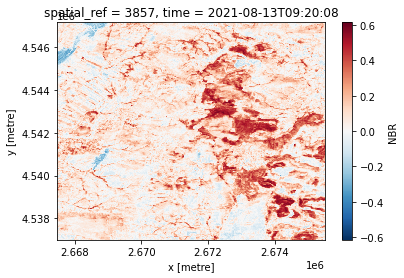

In [120]:
prefire_burnratio.plot()

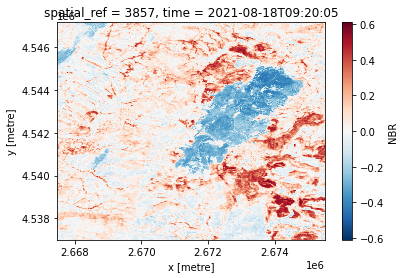

In [121]:
postfire_burnratio.plot()

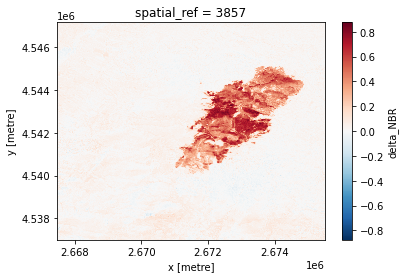

In [123]:
dnbr_dataset.delta_NBR.plot()

## Summary
*Provide 3-5 bullet points summarising the main aspects of the pre-processing and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information

**License**: The code in this notebook is licensed under the MIT License.

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue]() or send a direct message to [](mailto:xxx@gmail.com).

In [114]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-07-18
